# Link to Dataset : [https://drive.google.com/file/d/1hPpCmqV5yy1yuHrQW6VYuZuyG74JLQVs/view?usp=sharing ]

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import sklearn
from sklearn.metrics import roc_auc_score


from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from tqdm.notebook import trange, tqdm
import time


In [2]:
image_size = 32
batch_size = 128
stats =  (0.5), (0.5)
data_dir = '/kaggle/input/mtp-assignment2/CfyMed'



In [3]:
train_ds = ImageFolder(data_dir+'/train', transform=T.Compose([
    T.RandomCrop(32, padding=4, padding_mode='reflect'),
    T.RandomHorizontalFlip(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

train_ds1 = ImageFolder(data_dir+'/train', transform=T.Compose([
    T.Resize(227),
    T.CenterCrop(227),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl1 = DataLoader(train_ds1, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [4]:
val_ds = ImageFolder(data_dir+'/val', transform=T.Compose([
    T.RandomCrop(32, padding=4, padding_mode='reflect'),
    T.RandomHorizontalFlip(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)]))

val_dl = DataLoader(val_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

val_ds1 = ImageFolder(data_dir+'/val', transform=T.Compose([
    T.Resize(227),
    T.CenterCrop(227),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)]))

val_dl1 = DataLoader(val_ds1, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [5]:
test_ds = ImageFolder(data_dir+'/test', transform=T.Compose([
    T.RandomCrop(32, padding=4, padding_mode='reflect'),
    T.RandomHorizontalFlip(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)]))

test_dl = DataLoader(test_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

test_ds1 = ImageFolder(data_dir+'/test', transform=T.Compose([
    T.Resize(227),
    T.CenterCrop(227),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats)]))

test_dl1 = DataLoader(test_ds1, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1] + stats[0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cpu')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl,device)
test_dl = DeviceDataLoader(test_dl,device)

train_dl1 = DeviceDataLoader(train_dl1, device)
val_dl1 = DeviceDataLoader(val_dl1,device)
test_dl1 = DeviceDataLoader(test_dl1,device)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim=1024, output_dim =2):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.hidden_fc2 = nn.Linear(100,32)
        self.output_fc = nn.Linear(32, output_dim)
        self.output_fc2 = nn.LogSoftmax(dim=0)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))
        h_3 = F.relu(self.hidden_fc2(h_2))

        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_3)
        y_pred = self.output_fc2(y_pred)

        # y_pred = [batch size, output dim]

        return y_pred

In [12]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120, 
                           kernel_size = 5, stride = 1, padding = 0)
    self.linear1 = nn.Linear(120, 64)
    self.linear2 = nn.Linear(64, 2)
    self.tanh = nn.Tanh()
    self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)
    self.out = nn.LogSoftmax(dim=0)

  def forward(self, x):
    x = self.conv1(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv2(x)
    x = self.tanh(x)
    x = self.avgpool(x)
    x = self.conv3(x)
    x = self.tanh(x)
    #print(x.shape)
    x = x.reshape(x.shape[0], -1)
    x = self.linear1(x)
    x = self.tanh(x)
    x = self.linear2(x)
    x = self.out(x)
    return x


In [13]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes),
            nn.LogSoftmax(dim=0))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [14]:
class VGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=0))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
criterion = nn.NLLLoss()

In [17]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)
        #auc_score = roc_auc_score(y_pred,y)
        

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)
            auc = roc_auc_score(y.data,y_pred.T[1])
            print("auc_score: ",auc)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator),auc

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
def fit(epochs, model, train_loader, val_loader,device, opt_func,loss_func = nn.NLLLoss()):
    EPOCHS = epochs
    #opt_func = optimizer(model.parameters(),lr = 0.1)
    train_loss_vec = []
    train_acc_vec = []
    val_loss_vec = []
    val_acc_vec = []
    auc_score_vec = []

    best_valid_loss = float('inf')

    for epoch in trange(EPOCHS):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, opt_func, loss_func, device)
        valid_loss, valid_acc , auc = evaluate(model, val_loader, criterion, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut1-model.pt')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        train_loss_vec.append(train_loss)
        val_loss_vec.append(valid_loss)
        val_acc_vec.append(valid_acc)
        train_acc_vec.append(train_acc)
        auc_score_vec.append(auc)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.5f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.5f} |  Val. Acc: {valid_acc*100:.2f}%| val_auc_score:{auc:.5f}')
    res = dict()
    res['training_loss'] = train_loss_vec
    res['validation_loss'] = val_loss_vec
    res['training_accuracy'] = train_acc_vec
    res['validation_accuracy'] = val_acc_vec
    res['auc_score'] = auc_score_vec
    
    return res

In [22]:
model = MLP()
to_device(model,device)
res_mlp = fit(10,model,train_dl,val_dl,device,optim.Adam(model.parameters(),lr=0.001))

print(f'The model has {count_parameters(model):,} trainable parameters')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.46875
Epoch: 01 | Epoch Time: 1m 22s
	Train Loss: 4.84493 | Train Acc: 57.16%
	 Val. Loss: 2.78053 |  Val. Acc: 50.00%| val_auc_score:0.46875


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.4375
Epoch: 02 | Epoch Time: 0m 56s
	Train Loss: 4.84512 | Train Acc: 53.50%
	 Val. Loss: 2.79497 |  Val. Acc: 37.50%| val_auc_score:0.43750


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.484375
Epoch: 03 | Epoch Time: 0m 59s
	Train Loss: 4.84583 | Train Acc: 55.34%
	 Val. Loss: 2.77369 |  Val. Acc: 62.50%| val_auc_score:0.48438


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.6875
Epoch: 04 | Epoch Time: 1m 1s
	Train Loss: 4.84499 | Train Acc: 56.72%
	 Val. Loss: 2.76733 |  Val. Acc: 56.25%| val_auc_score:0.68750


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.5
Epoch: 05 | Epoch Time: 0m 58s
	Train Loss: 4.84529 | Train Acc: 56.18%
	 Val. Loss: 2.76506 |  Val. Acc: 56.25%| val_auc_score:0.50000


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.5390625
Epoch: 06 | Epoch Time: 0m 56s
	Train Loss: 4.84541 | Train Acc: 55.03%
	 Val. Loss: 2.77349 |  Val. Acc: 56.25%| val_auc_score:0.53906


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.34375
Epoch: 07 | Epoch Time: 0m 56s
	Train Loss: 4.84524 | Train Acc: 59.37%
	 Val. Loss: 2.77095 |  Val. Acc: 56.25%| val_auc_score:0.34375


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.546875
Epoch: 08 | Epoch Time: 0m 55s
	Train Loss: 4.84475 | Train Acc: 55.01%
	 Val. Loss: 2.77748 |  Val. Acc: 43.75%| val_auc_score:0.54688


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.5
Epoch: 09 | Epoch Time: 0m 57s
	Train Loss: 4.84536 | Train Acc: 53.61%
	 Val. Loss: 2.77821 |  Val. Acc: 43.75%| val_auc_score:0.50000


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.25
Epoch: 10 | Epoch Time: 0m 56s
	Train Loss: 4.84531 | Train Acc: 56.66%
	 Val. Loss: 2.76873 |  Val. Acc: 68.75%| val_auc_score:0.25000
The model has 284,648 trainable parameters


In [23]:
model = LeNet()
to_device(model,device)
res_lenet = fit(10,model,train_dl,val_dl,device,optim.Adam(model.parameters(),lr=0.001))

print(f'The model has {count_parameters(model):,} trainable parameters')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.40625
Epoch: 01 | Epoch Time: 0m 57s
	Train Loss: 4.84558 | Train Acc: 53.06%
	 Val. Loss: 2.77301 |  Val. Acc: 43.75%| val_auc_score:0.40625


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.484375
Epoch: 02 | Epoch Time: 0m 57s
	Train Loss: 4.84527 | Train Acc: 52.99%
	 Val. Loss: 2.77483 |  Val. Acc: 56.25%| val_auc_score:0.48438


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.390625
Epoch: 03 | Epoch Time: 0m 58s
	Train Loss: 4.84525 | Train Acc: 52.93%
	 Val. Loss: 2.77461 |  Val. Acc: 43.75%| val_auc_score:0.39062


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.625
Epoch: 04 | Epoch Time: 0m 57s
	Train Loss: 4.84517 | Train Acc: 53.32%
	 Val. Loss: 2.77011 |  Val. Acc: 62.50%| val_auc_score:0.62500


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.515625
Epoch: 05 | Epoch Time: 0m 58s
	Train Loss: 4.84512 | Train Acc: 53.63%
	 Val. Loss: 2.77183 |  Val. Acc: 56.25%| val_auc_score:0.51562


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.484375
Epoch: 06 | Epoch Time: 0m 56s
	Train Loss: 4.84476 | Train Acc: 56.55%
	 Val. Loss: 2.77440 |  Val. Acc: 43.75%| val_auc_score:0.48438


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.21875
Epoch: 07 | Epoch Time: 0m 57s
	Train Loss: 4.84529 | Train Acc: 53.79%
	 Val. Loss: 2.77292 |  Val. Acc: 37.50%| val_auc_score:0.21875


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.546875
Epoch: 08 | Epoch Time: 0m 57s
	Train Loss: 4.84516 | Train Acc: 50.58%
	 Val. Loss: 2.77123 |  Val. Acc: 56.25%| val_auc_score:0.54688


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.421875
Epoch: 09 | Epoch Time: 0m 56s
	Train Loss: 4.84509 | Train Acc: 56.45%
	 Val. Loss: 2.77342 |  Val. Acc: 43.75%| val_auc_score:0.42188


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.484375
Epoch: 10 | Epoch Time: 0m 57s
	Train Loss: 4.84509 | Train Acc: 53.69%
	 Val. Loss: 2.77310 |  Val. Acc: 50.00%| val_auc_score:0.48438
The model has 58,566 trainable parameters


In [24]:
model = VGG16()
to_device(model,device)
res_vgg = fit(10,model,train_dl,val_dl,device,optim.Adam(model.parameters(),lr=0.0001))

print(f'The model has {count_parameters(model):,} trainable parameters')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.578125
Epoch: 01 | Epoch Time: 3m 7s
	Train Loss: 4.83514 | Train Acc: 60.97%
	 Val. Loss: 2.75658 |  Val. Acc: 56.25%| val_auc_score:0.57812


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.640625
Epoch: 02 | Epoch Time: 2m 54s
	Train Loss: 4.69997 | Train Acc: 72.97%
	 Val. Loss: 3.00869 |  Val. Acc: 68.75%| val_auc_score:0.64062


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.8125
Epoch: 03 | Epoch Time: 2m 48s
	Train Loss: 4.60129 | Train Acc: 81.54%
	 Val. Loss: 2.76383 |  Val. Acc: 62.50%| val_auc_score:0.81250


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.921875
Epoch: 04 | Epoch Time: 2m 49s
	Train Loss: 4.53095 | Train Acc: 86.27%
	 Val. Loss: 2.45945 |  Val. Acc: 81.25%| val_auc_score:0.92188


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.859375
Epoch: 05 | Epoch Time: 2m 47s
	Train Loss: 4.45764 | Train Acc: 90.71%
	 Val. Loss: 2.95304 |  Val. Acc: 68.75%| val_auc_score:0.85938


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.90625
Epoch: 06 | Epoch Time: 2m 47s
	Train Loss: 4.43762 | Train Acc: 91.74%
	 Val. Loss: 3.10185 |  Val. Acc: 68.75%| val_auc_score:0.90625


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.90625
Epoch: 07 | Epoch Time: 2m 47s
	Train Loss: 4.42202 | Train Acc: 92.44%
	 Val. Loss: 2.66192 |  Val. Acc: 75.00%| val_auc_score:0.90625


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.921875
Epoch: 08 | Epoch Time: 2m 46s
	Train Loss: 4.41342 | Train Acc: 92.76%
	 Val. Loss: 2.89416 |  Val. Acc: 68.75%| val_auc_score:0.92188


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.765625
Epoch: 09 | Epoch Time: 2m 47s
	Train Loss: 4.40930 | Train Acc: 93.99%
	 Val. Loss: 3.63588 |  Val. Acc: 68.75%| val_auc_score:0.76562


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.5625
Epoch: 10 | Epoch Time: 2m 48s
	Train Loss: 4.39284 | Train Acc: 93.89%
	 Val. Loss: 3.87340 |  Val. Acc: 62.50%| val_auc_score:0.56250
The model has 14,919,618 trainable parameters


In [25]:
model = AlexNet()
to_device(model,device)
res_alex = fit(10,model,train_dl1,val_dl1,device,optim.Adam(model.parameters(),lr=0.001))

print(f'The model has {count_parameters(model):,} trainable parameters')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.5625
Epoch: 01 | Epoch Time: 7m 25s
	Train Loss: 12.08125 | Train Acc: 67.38%
	 Val. Loss: 2.68873 |  Val. Acc: 75.00%| val_auc_score:0.56250


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.78125
Epoch: 02 | Epoch Time: 7m 33s
	Train Loss: 4.60798 | Train Acc: 85.16%
	 Val. Loss: 2.70827 |  Val. Acc: 68.75%| val_auc_score:0.78125


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.90625
Epoch: 03 | Epoch Time: 7m 52s
	Train Loss: 4.52434 | Train Acc: 89.12%
	 Val. Loss: 2.44862 |  Val. Acc: 93.75%| val_auc_score:0.90625


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.921875
Epoch: 04 | Epoch Time: 7m 40s
	Train Loss: 4.49171 | Train Acc: 90.47%
	 Val. Loss: 2.50650 |  Val. Acc: 81.25%| val_auc_score:0.92188


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.65625
Epoch: 05 | Epoch Time: 7m 19s
	Train Loss: 4.45749 | Train Acc: 92.09%
	 Val. Loss: 3.44664 |  Val. Acc: 68.75%| val_auc_score:0.65625


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.84375
Epoch: 06 | Epoch Time: 7m 26s
	Train Loss: 4.44541 | Train Acc: 92.50%
	 Val. Loss: 2.51526 |  Val. Acc: 75.00%| val_auc_score:0.84375


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.40625
Epoch: 07 | Epoch Time: 7m 32s
	Train Loss: 4.42734 | Train Acc: 93.48%
	 Val. Loss: 2.96420 |  Val. Acc: 75.00%| val_auc_score:0.40625


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.859375
Epoch: 08 | Epoch Time: 7m 25s
	Train Loss: 4.42232 | Train Acc: 93.93%
	 Val. Loss: 2.78644 |  Val. Acc: 62.50%| val_auc_score:0.85938


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.859375
Epoch: 09 | Epoch Time: 7m 26s
	Train Loss: 4.39504 | Train Acc: 94.87%
	 Val. Loss: 2.58382 |  Val. Acc: 62.50%| val_auc_score:0.85938


Training:   0%|          | 0/41 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

auc_score:  0.78125
Epoch: 10 | Epoch Time: 7m 23s
	Train Loss: 4.38658 | Train Acc: 95.31%
	 Val. Loss: 2.92023 |  Val. Acc: 68.75%| val_auc_score:0.78125
The model has 58,269,058 trainable parameters


In [26]:
x = [i for i in range(10)]
res_lenet['training_loss']


[4.8455767980435995,
 4.845272785279809,
 4.845254863180766,
 4.845172742517983,
 4.84511605704703,
 4.844759452633742,
 4.845287439299793,
 4.845158576965332,
 4.845085132412795,
 4.845085492948207]

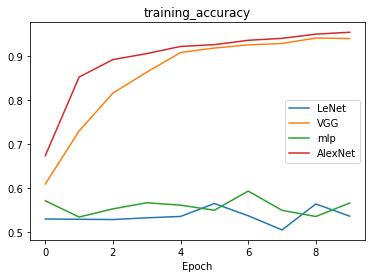

In [27]:
plt.plot(x, res_lenet['training_accuracy'], label='LeNet')
plt.plot(x, res_vgg['training_accuracy'], label='VGG')
plt.plot(x, res_mlp['training_accuracy'], label='mlp')
plt.plot(x, res_alex['training_accuracy'],label ='AlexNet')
plt.title('training_accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()



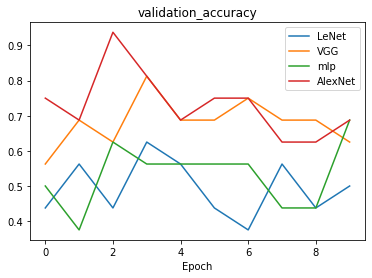

In [28]:
plt.plot(x, res_lenet['validation_accuracy'], label='LeNet')
plt.plot(x, res_vgg['validation_accuracy'], label='VGG')
plt.plot(x, res_mlp['validation_accuracy'], label='mlp')
plt.plot(x, res_alex['validation_accuracy'],label ='AlexNet')
plt.title('validation_accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

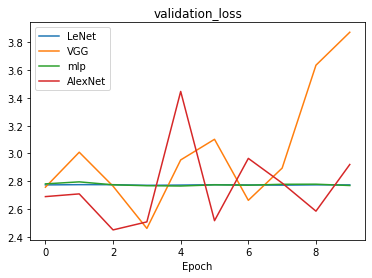

In [29]:
plt.plot(x, res_lenet['validation_loss'], label='LeNet')
plt.plot(x, res_vgg['validation_loss'], label='VGG')
plt.plot(x, res_mlp['validation_loss'], label='mlp')
plt.plot(x, res_alex['validation_loss'],label ='AlexNet')
plt.title('validation_loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

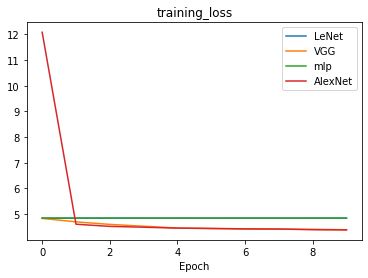

In [30]:
plt.plot(x, res_lenet['training_loss'], label='LeNet')
plt.plot(x, res_vgg['training_loss'], label='VGG')
plt.plot(x, res_mlp['training_loss'], label='mlp')
plt.plot(x, res_alex['training_loss'],label ='AlexNet')
plt.title('training_loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

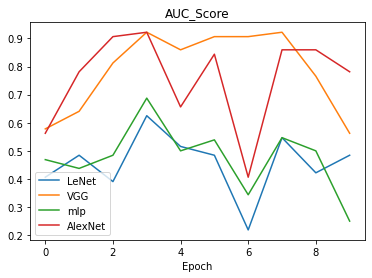

In [31]:
plt.plot(x, res_lenet['auc_score'], label='LeNet')
plt.plot(x, res_vgg['auc_score'], label='VGG')
plt.plot(x, res_mlp['auc_score'], label='mlp')
plt.plot(x, res_alex['auc_score'],label ='AlexNet')
plt.title('AUC_Score')
plt.xlabel("Epoch")
plt.legend()
plt.show()